In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
    VotingRegressor,
)
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

plt.style.use("fivethirtyeight")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
warnings.filterwarnings("ignore")

In [2]:
train_filename = "train.csv"
test_filename = "test.csv"

real_train_df = pd.read_csv(train_filename, index_col="Id")
real_test_df = pd.read_csv(test_filename, index_col="Id")
target_col = "SalePrice"

In [3]:
def get_basic_information(df):
    desc = pd.DataFrame(index=list(df.columns))
    desc["count"] = df.count()
    desc["nunique"] = df.nunique()
    desc["null"] = df.isnull().sum()
    desc["type"] = df.dtypes
    desc = pd.concat([desc, df.describe().T], axis=1)
    return desc

In [4]:
real_train_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                       
1        Norm     1Fam     2Story            7            5       2003   
2        Norm     1Fam     1Story            6            8       1976   
3        Norm     1Fam     2Story            7            5       2001   
4        Norm     1Fam     2Story            7            5       1915   
5        Norm     1Fam     2Story            8            5       2000   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1           2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2           1976     Gable  CompShg     MetalSd     MetalSd       None   
3           2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4           1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
5           2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                             
1        196.0        Gd        TA      PConc       Gd       TA           No   
2          0.0        TA        TA     CBlock       Gd       TA           Gd   
3        162.0        Gd        TA      PConc       Gd       TA           Mn   
4          0.0        TA        TA     BrkTil       TA       Gd           No   
5        350.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                             
1           GLQ         706          Unf           0        150          856   
2           ALQ         978          Unf           0        284         1262   
3           GLQ         486          Unf           0        434          920   
4           ALQ         216          Unf           0        540          756   
5           GLQ         655          Unf           0        490         1145   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                             
1     GasA        Ex          Y      SBrkr       856       854             0   
2     GasA        Ex          Y      SBrkr      1262         0             0   
3     GasA        Ex          Y      SBrkr       920       866             0   
4     GasA        Gd          Y      SBrkr       961       756             0   
5     GasA        Ex          Y      SBrkr      1145      1053             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                            
1        1710             1             0         2         1             3   
2        1262             0             1  

In [5]:
get_basic_information(real_train_df)

count  nunique  null     type   count           mean  \
MSSubClass      1460       15     0    int64  1460.0      56.897260   
MSZoning        1460        5     0   object     NaN            NaN   
LotFrontage     1201      110   259  float64  1201.0      70.049958   
LotArea         1460     1073     0    int64  1460.0   10516.828082   
Street          1460        2     0   object     NaN            NaN   
Alley             91        2  1369   object     NaN            NaN   
LotShape        1460        4     0   object     NaN            NaN   
LandContour     1460        4     0   object     NaN            NaN   
Utilities       1460        2     0   object     NaN            NaN   
LotConfig       1460        5     0   object     NaN            NaN   
LandSlope       1460        3     0   object     NaN            NaN   
Neighborhood    1460       25     0   object     NaN            NaN   
Condition1      1460        9     0   object     NaN            NaN   
Condition2      1460        8     0   object     NaN            NaN   
BldgType        1460        5     0   object     NaN            NaN   
HouseStyle      1460        8     0   object     NaN            NaN   
OverallQual     1460       10     0    int64  1460.0       6.099315   
OverallCond     1460        9     0    int64  1460.0       5.575342   
YearBuilt       1460      112     0    int64  1460.0    1971.267808   
YearRemodAdd    1460       61     0    int64  1460.0    1984.865753   
RoofStyle       1460        6     0   object     NaN            NaN   
RoofMatl        1460        8     0   object     NaN            NaN   
Exterior1st     1460       15     0   object     NaN            NaN   
Exterior2nd     1460       16     0   object     NaN            NaN   
MasVnrType      1452        4     8   object     NaN            NaN   
MasVnrArea      1452      327     8  float64  1452.0     103.685262   
ExterQual       1460        4     0   object     NaN            NaN   
ExterCond       1460        5     0   object     NaN            NaN   
Foundation      1460        6     0   object     NaN            NaN   
BsmtQual        1423        4    37   object     NaN            NaN   
BsmtCond        1423        4    37   object     NaN            NaN   
BsmtExposure    1422        4    38   object     NaN            NaN   
BsmtFinType1    1423        6    37   object     NaN            NaN   
BsmtFinSF1      1460      637     0    int64  1460.0     443.639726   
BsmtFinType2    1422        6    38   object     NaN            NaN   
BsmtFinSF2      1460      144     0    int64  1460.0      46.549315   
BsmtUnfSF       1460      780     0    int64  1460.0     567.240411   
TotalBsmtSF     1460      721     0    int64  1460.0    1057.429452   
Heating         1460        6     0   object     NaN            NaN   
HeatingQC       1460        5     0   object     NaN            NaN   
CentralAir      1460        2     0   object     NaN            NaN   
Electrical      1459        5     1   object     NaN            NaN   
1stFlrSF        1460      753     0    int64  1460.0    1162.626712   
2ndFlrSF        1460      417     0    int64  1460.0     346.992466   
LowQualFinSF    1460       24     0    int64  1460.0       5.844521   
GrLivArea       1460      861     0    int64  1460.0    1515.463699   
BsmtFullBath    1460        4     0    int64  1460.0       0.425342   
BsmtHalfBath    1460        3     0    int64  1460.0       0.057534   
FullBath        1460        4     0    int64  1460.0       1.565068   
HalfBath        1460        3     0    int64  1460.0       0.382877   
BedroomAbvGr    1460        8     0    int64  1460.0       2.866438   
KitchenAbvGr    1460        4     0    int64  1460.0       1.046575   
KitchenQual     1460        4     0   object     NaN            NaN   
TotRmsAbvGrd    1460       12     0    int64  1460.0       6.517808   
Functional      1460        7     0   object     NaN            NaN   
Fireplaces      1460        4     0    

In [6]:
real_test_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave   NaN      Reg   
1462          20       RL         81.0    14267   Pave   NaN      IR1   
1463          60       RL         74.0    13830   Pave   NaN      IR1   
1464          60       RL         78.0     9978   Pave   NaN      IR1   
1465         120       RL         43.0     5005   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
1461         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1462         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
1463         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1464         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1465         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                         
1461       Norm     1Fam     1Story            5            6       1961   
1462       Norm     1Fam     1Story            6            6       1958   
1463       Norm     1Fam     2Story            5            5       1997   
1464       Norm     1Fam     2Story            6            6       1998   
1465       Norm   TwnhsE     1Story            8            5       1992   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
1461          1961     Gable  CompShg     VinylSd     VinylSd       None   
1462          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
1463          1998     Gable  CompShg     VinylSd     VinylSd       None   
1464          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1465          1992     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
1461         0.0        TA        TA     CBlock       TA       TA   
1462       108.0        TA        TA     CBlock       TA       TA   
1463         0.0        TA        TA      PConc       Gd       TA   
1464        20.0        TA        TA      PConc       TA       TA   
1465         0.0        Gd        TA      PConc       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
Id                                                                    
1461           No          Rec       468.0          LwQ       144.0   
1462           No          ALQ       923.0          Unf         0.0   
1463           No          GLQ       791.0          Unf         0.0   
1464           No          GLQ       602.0          Unf         0.0   
1465           No          ALQ       263.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
Id                                                                     
1461      270.0        882.0    GasA        TA          Y      SBrkr   
1462      406.0       1329.0    GasA        TA          Y      SBrkr   
1463      137.0        928.0    GasA        Gd          Y      SBrkr   
1464      324.0        926.0    GasA        Ex          Y      SBrkr   
1465     1017.0       1280.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
Id                                                                              
1461       896         0             0        896           0.0           0.0   
1462      1329         0             0       1329           0.0           0.0   
1463       928       701             0       1629           0.0           0.0   
1464       926   

In [7]:
get_basic_information(real_test_df)

count  nunique  null     type   count         mean  \
MSSubClass      1459       16     0    int64  1459.0    57.378341   
MSZoning        1455        5     4   object     NaN          NaN   
LotFrontage     1232      115   227  float64  1232.0    68.580357   
LotArea         1459     1106     0    int64  1459.0  9819.161069   
Street          1459        2     0   object     NaN          NaN   
Alley            107        2  1352   object     NaN          NaN   
LotShape        1459        4     0   object     NaN          NaN   
LandContour     1459        4     0   object     NaN          NaN   
Utilities       1457        1     2   object     NaN          NaN   
LotConfig       1459        5     0   object     NaN          NaN   
LandSlope       1459        3     0   object     NaN          NaN   
Neighborhood    1459       25     0   object     NaN          NaN   
Condition1      1459        9     0   object     NaN          NaN   
Condition2      1459        5     0   object     NaN          NaN   
BldgType        1459        5     0   object     NaN          NaN   
HouseStyle      1459        7     0   object     NaN          NaN   
OverallQual     1459       10     0    int64  1459.0     6.078821   
OverallCond     1459        9     0    int64  1459.0     5.553804   
YearBuilt       1459      106     0    int64  1459.0  1971.357779   
YearRemodAdd    1459       61     0    int64  1459.0  1983.662783   
RoofStyle       1459        6     0   object     NaN          NaN   
RoofMatl        1459        4     0   object     NaN          NaN   
Exterior1st     1458       13     1   object     NaN          NaN   
Exterior2nd     1458       15     1   object     NaN          NaN   
MasVnrType      1443        4    16   object     NaN          NaN   
MasVnrArea      1444      303    15  float64  1444.0   100.709141   
ExterQual       1459        4     0   object     NaN          NaN   
ExterCond       1459        5     0   object     NaN          NaN   
Foundation      1459        6     0   object     NaN          NaN   
BsmtQual        1415        4    44   object     NaN          NaN   
BsmtCond        1414        4    45   object     NaN          NaN   
BsmtExposure    1415        4    44   object     NaN          NaN   
BsmtFinType1    1417        6    42   object     NaN          NaN   
BsmtFinSF1      1458      669     1  float64  1458.0   439.203704   
BsmtFinType2    1417        6    42   object     NaN          NaN   
BsmtFinSF2      1458      161     1  float64  1458.0    52.619342   
BsmtUnfSF       1458      793     1  float64  1458.0   554.294925   
TotalBsmtSF     1458      736     1  float64  1458.0  1046.117970   
Heating         1459        4     0   object     NaN          NaN   
HeatingQC       1459        5     0   object     NaN          NaN   
CentralAir      1459        2     0   object     NaN          NaN   
Electrical      1459        4     0   object     NaN          NaN   
1stFlrSF        1459      789     0    int64  1459.0  1156.534613   
2ndFlrSF        1459      407     0    int64  1459.0   325.967786   
LowQualFinSF    1459       15     0    int64  1459.0     3.543523   
GrLivArea       1459      879     0    int64  1459.0  1486.045922   
BsmtFullBath    1457        4     2  float64  1457.0     0.434454   
BsmtHalfBath    1457        3     2  float64  1457.0     0.065202   
FullBath        1459        5     0    int64  1459.0     1.570939   
HalfBath        1459        3     0    int64  1459.0     0.377656   
BedroomAbvGr    1459        7     0    int64  1459.0     2.854010   
KitchenAbvGr    1459        3     0    int64  1459.0     1.042495   
KitchenQual     1458        4     1   object     NaN          NaN   
TotRmsAbvGrd    1459       12     0    int64  1459.0     6.385195   
Functional      1457        7     2   object     NaN          NaN   
Fireplaces      1459        5     0    int64  1459.0     0.581220   
FireplaceQu      729        5   730   object     NaN          NaN   
GarageType   

In [52]:
numerical_features = list(real_test_df.select_dtypes(include="number").columns)
categorical_features = list(real_test_df.select_dtypes(exclude="number").columns)
print(numerical_features)
print(categorical_features)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCon

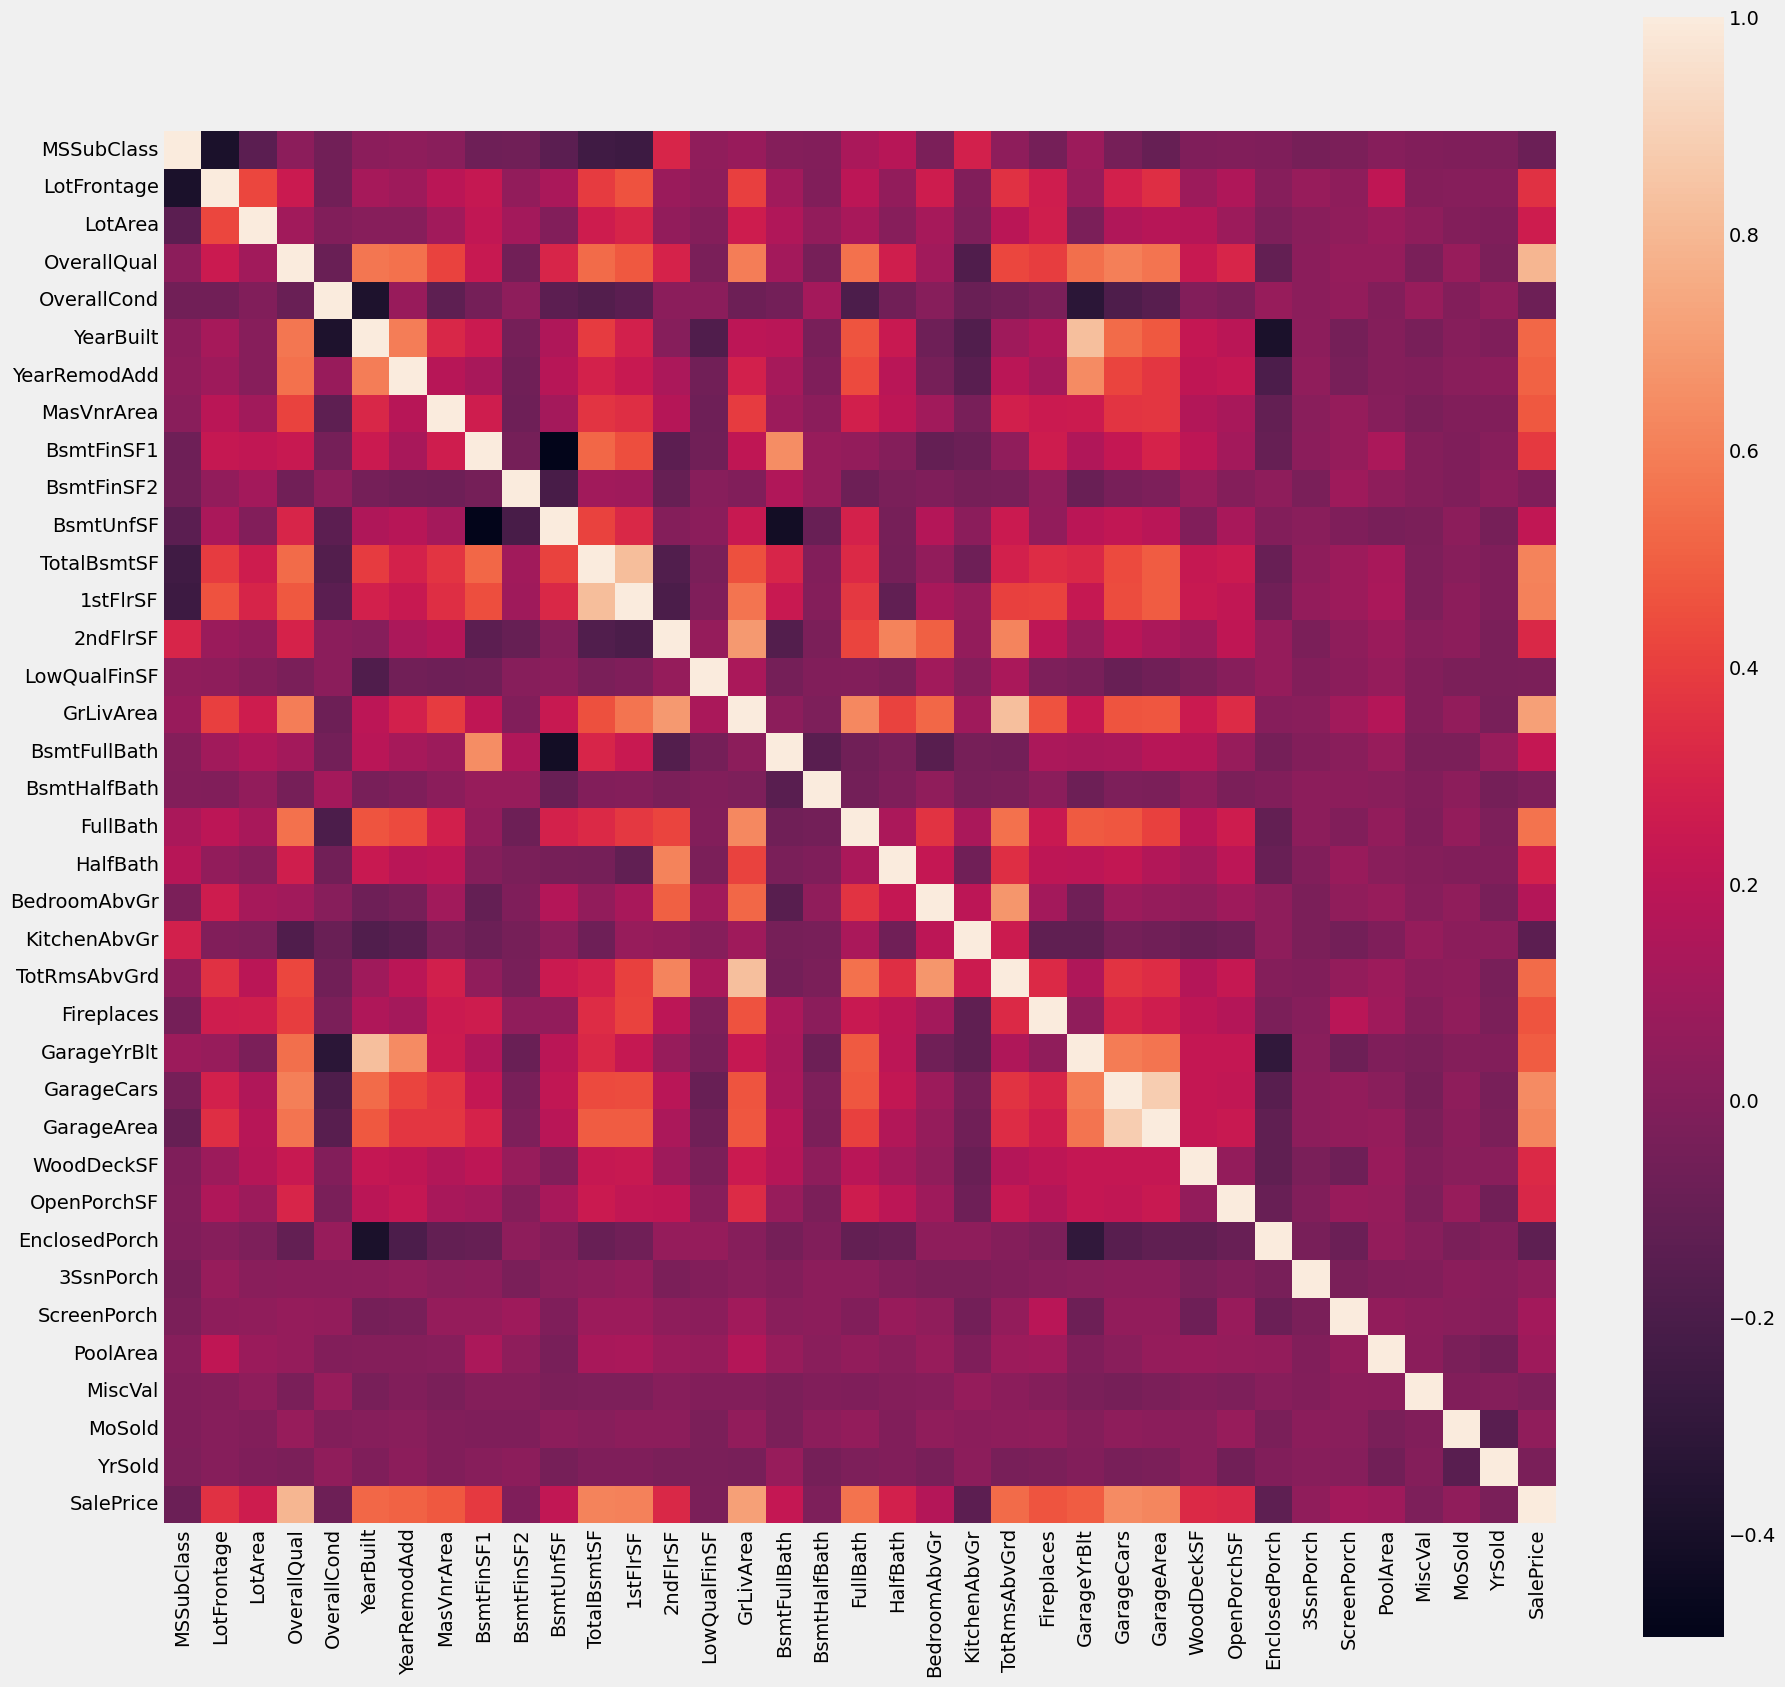

In [9]:
plt.figure(figsize=(20, 20))
sns.heatmap(real_train_df.corr(), square=True)
plt.show()

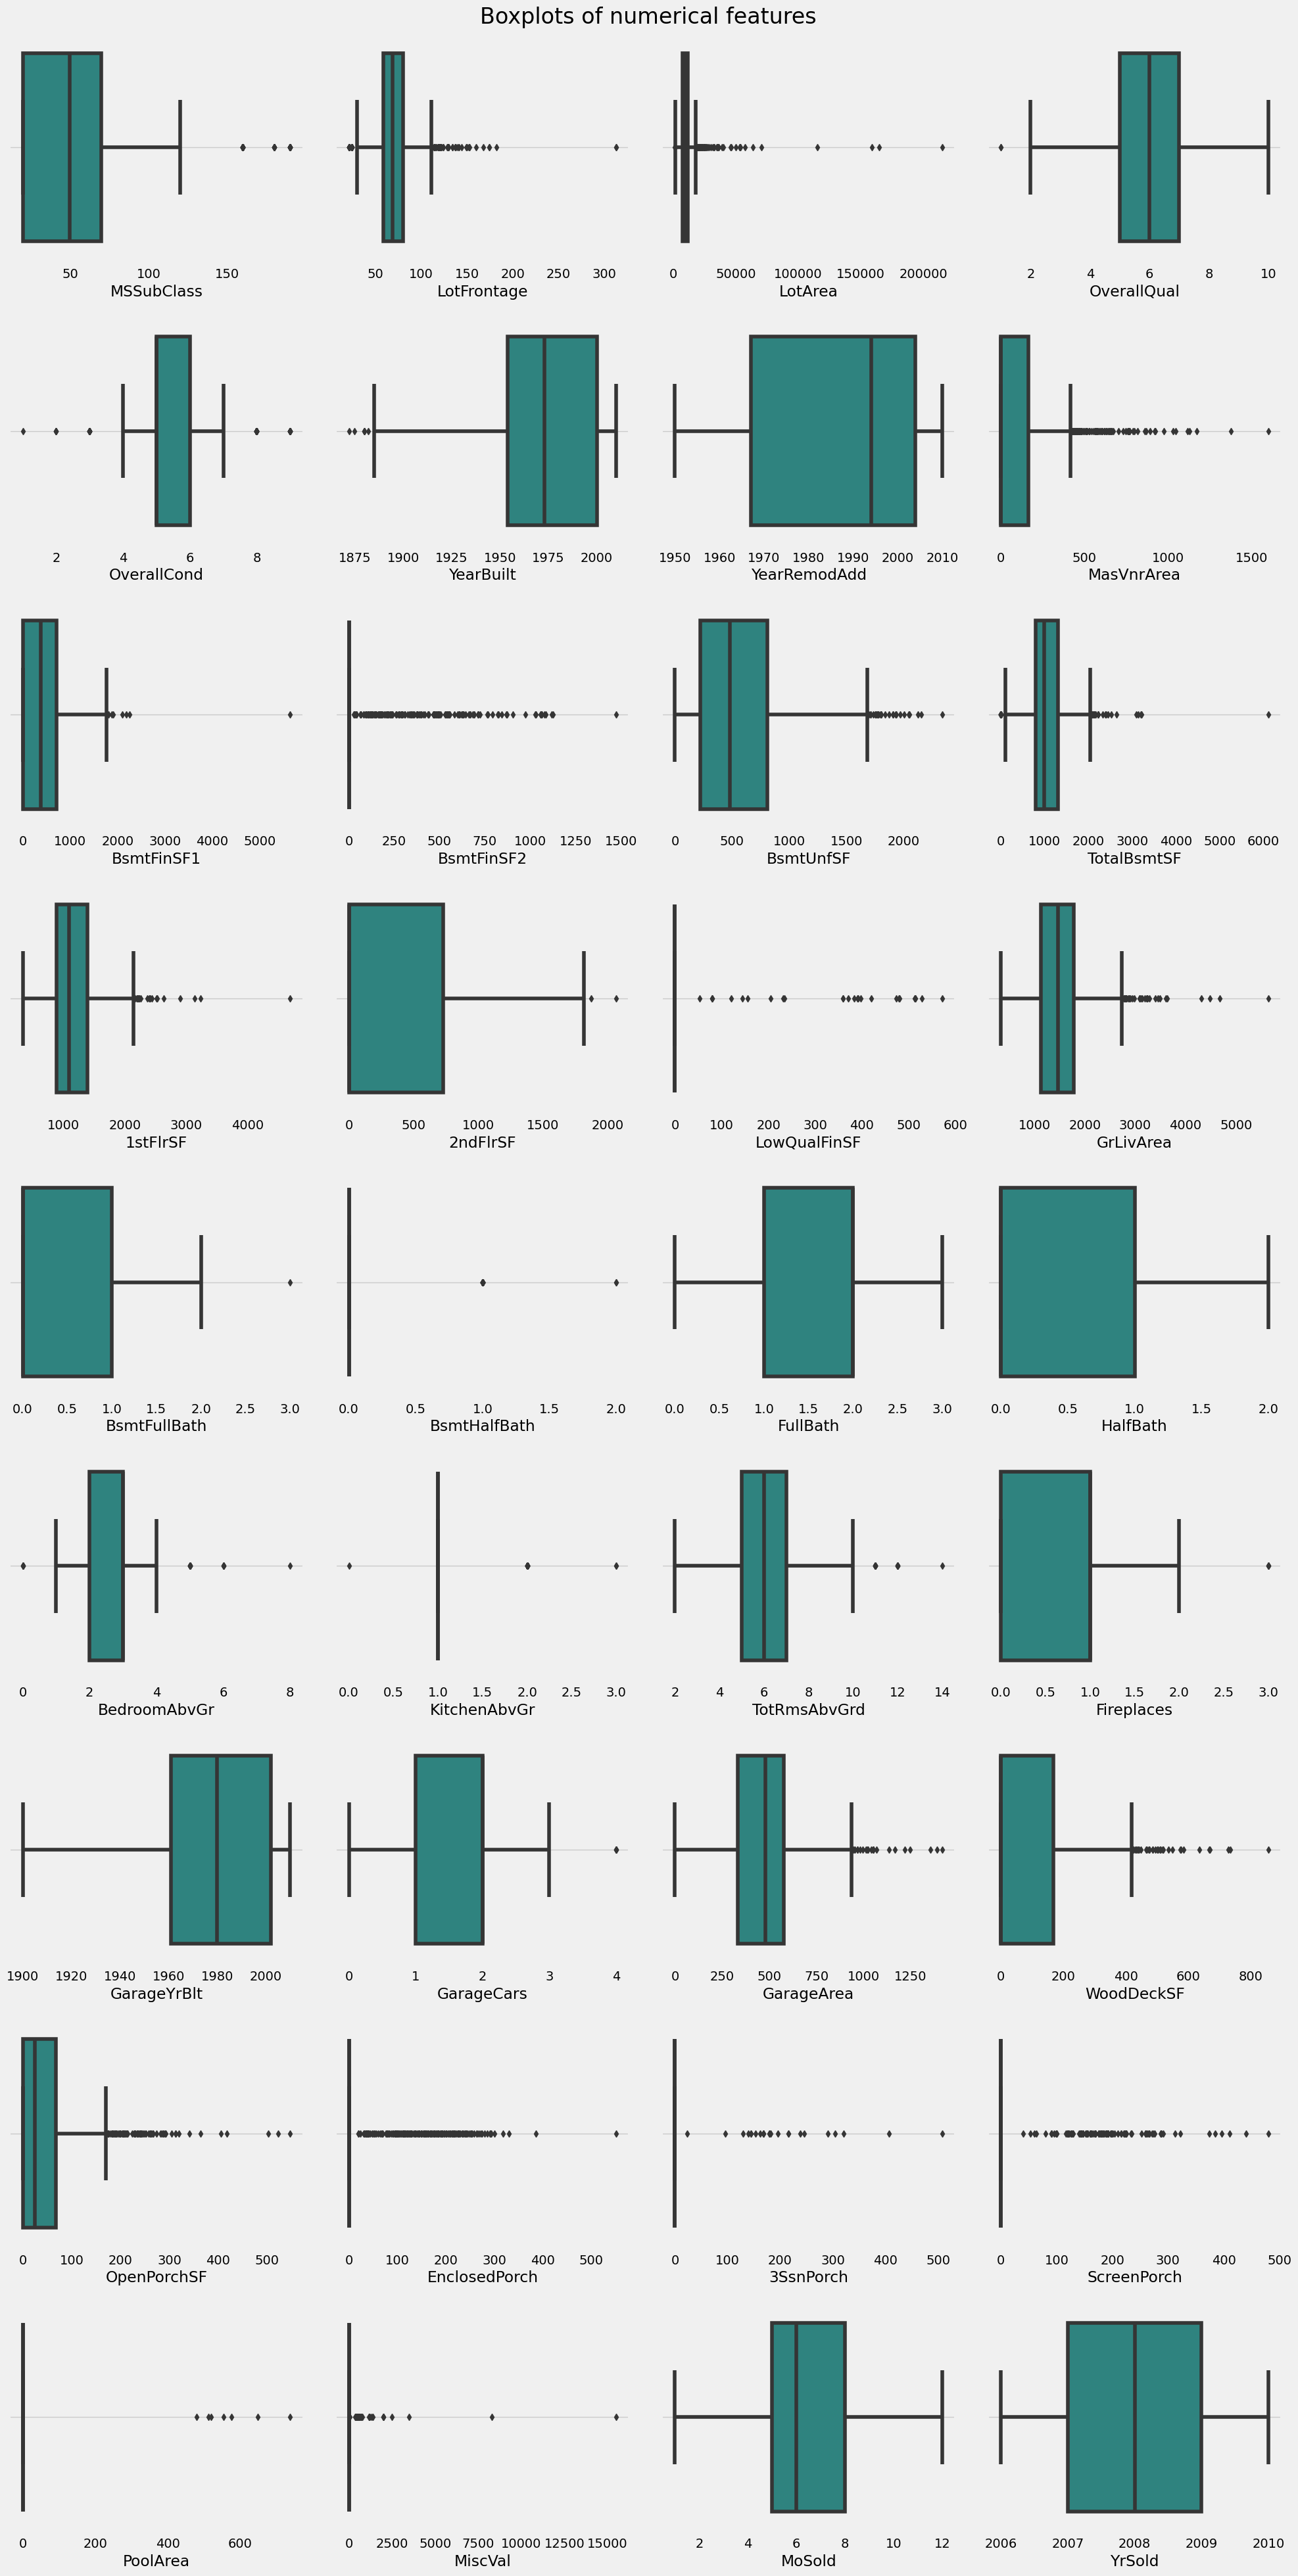

In [10]:
fig, axes = plt.subplots((len(numerical_features) + 3) // 4, 4, figsize=(20, 40))
axes = axes.flatten()
for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.boxplot(data=real_train_df, x=feature, ax=ax, palette="viridis")
    ax.grid(None)
fig.suptitle("Boxplots of numerical features", fontsize=24)
fig.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

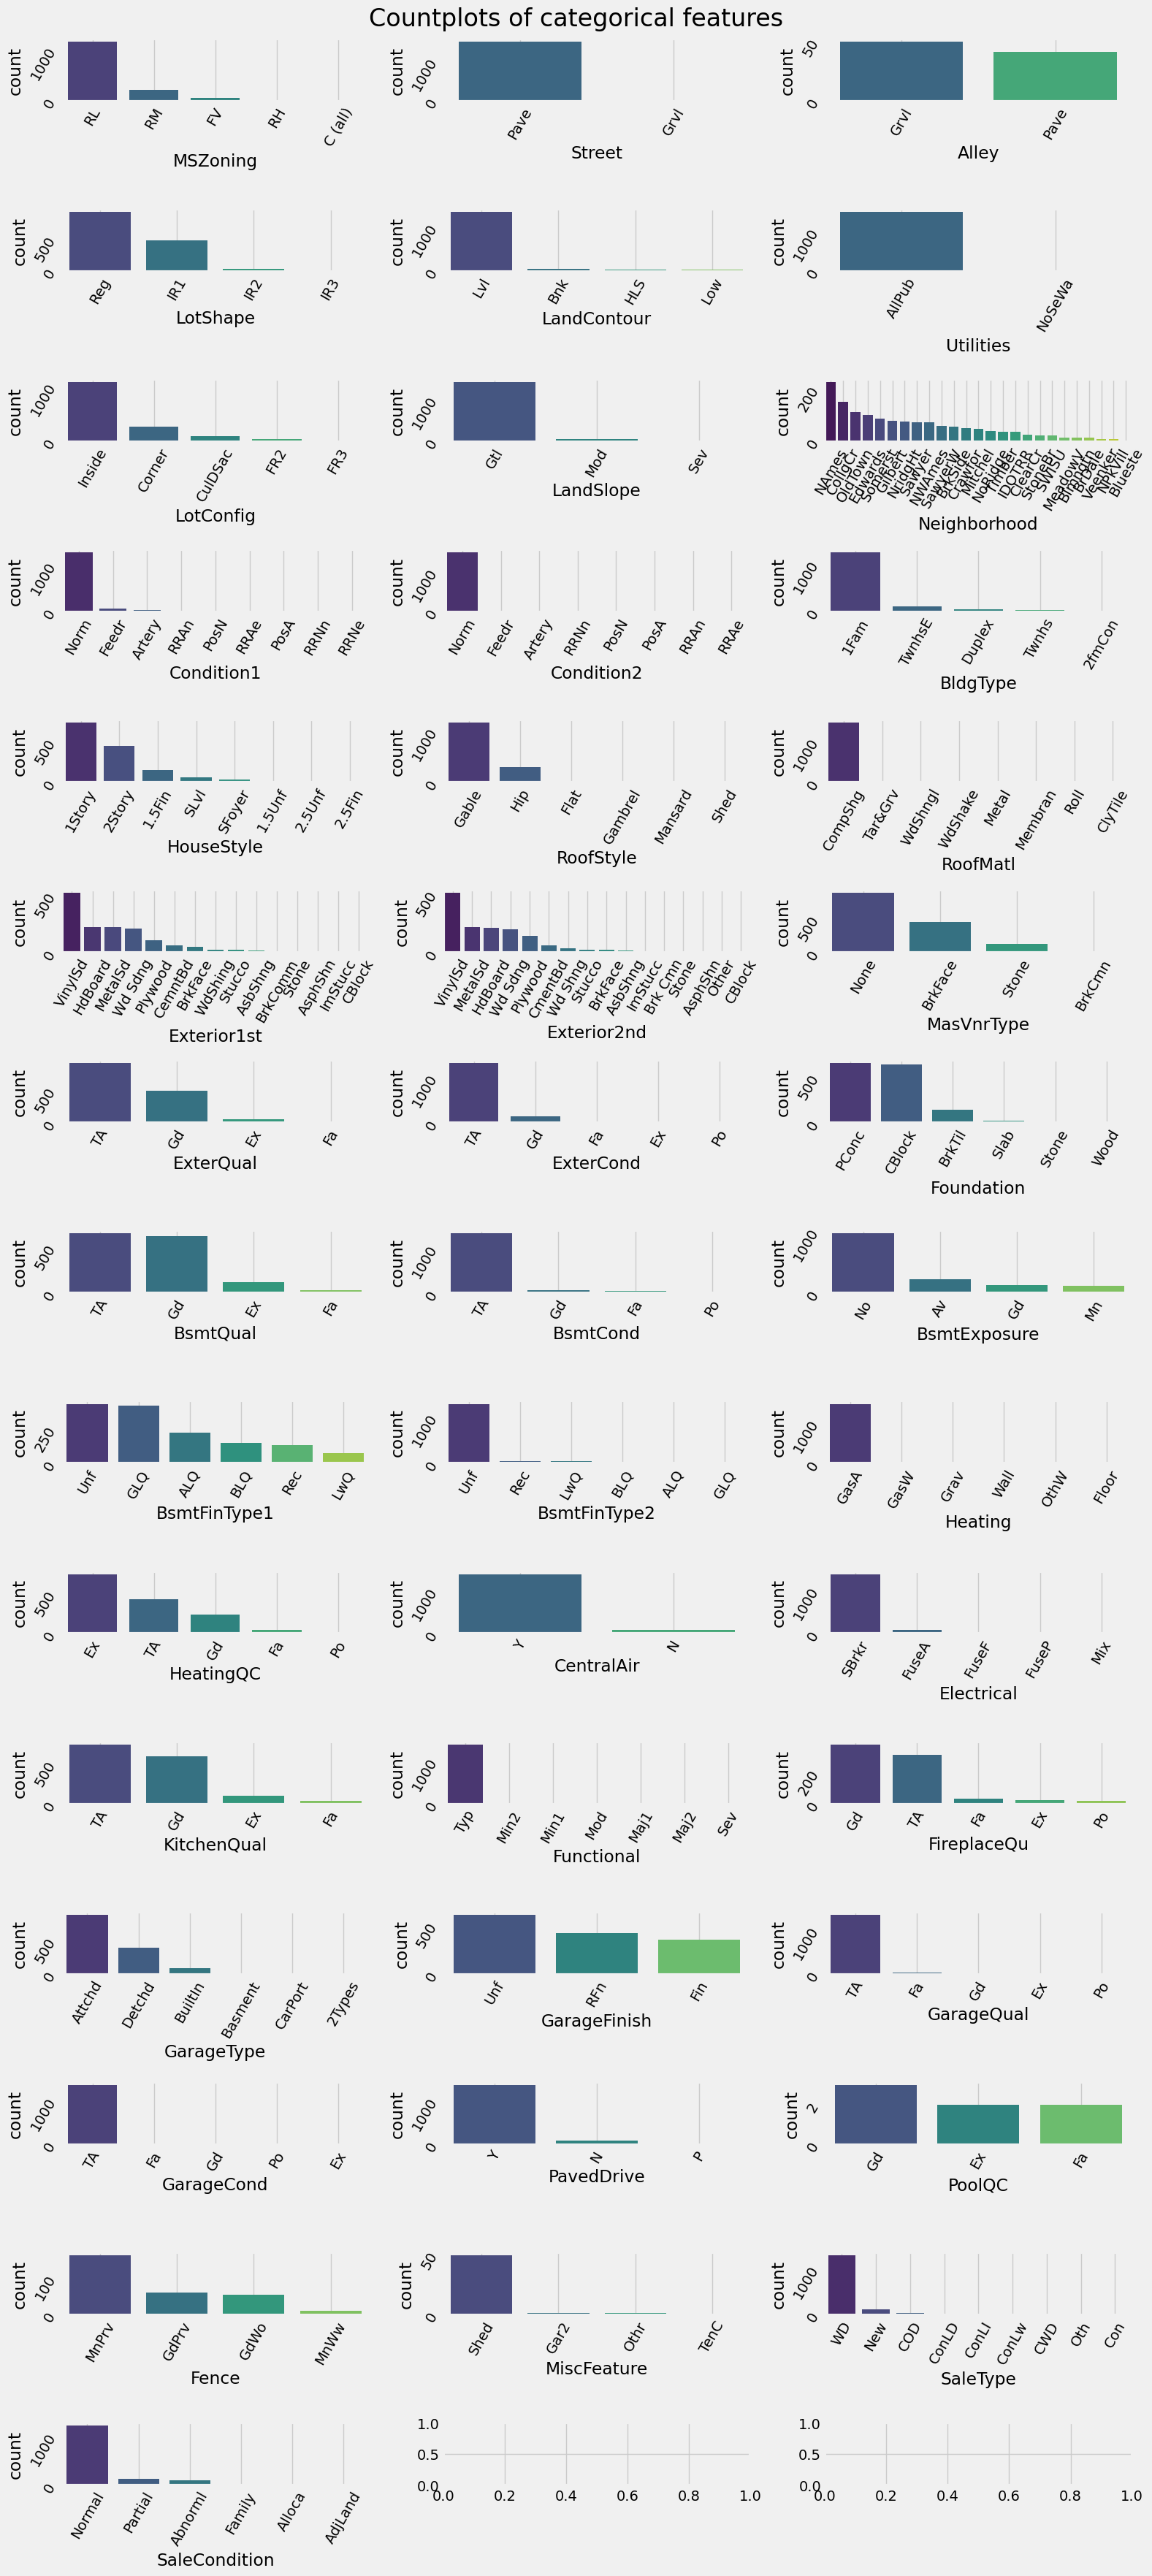

In [17]:
fig, axes = plt.subplots((len(categorical_features) + 2) // 3, 3, figsize=(16, 36))
axes = axes.flatten()
for i, feature in enumerate(categorical_features):
    ax = axes[i]
    ax.tick_params(labelrotation=60)
    sns.countplot(
        data=real_train_df,
        x=feature,
        ax=ax,
        palette="viridis",
        order=real_train_df[feature].value_counts().index,
    )
    ax.grid(None)
fig.suptitle("Countplots of categorical features", fontsize=24)
fig.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

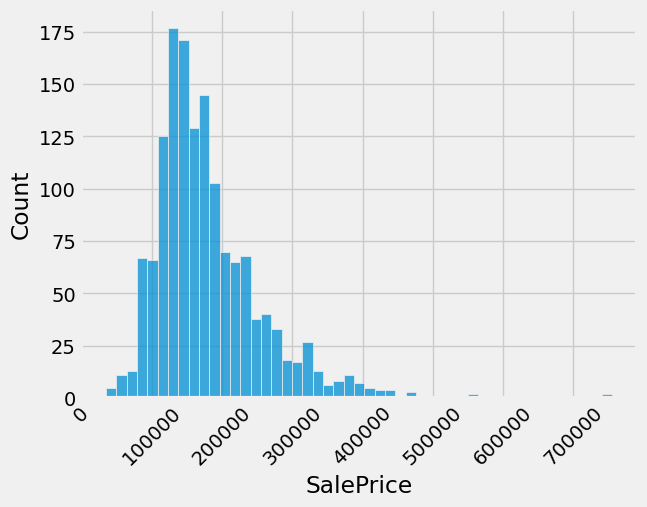

In [21]:
sns.histplot(data=real_train_df, x=target_col, palette="viridis")
plt.xticks(rotation=45)
plt.show()

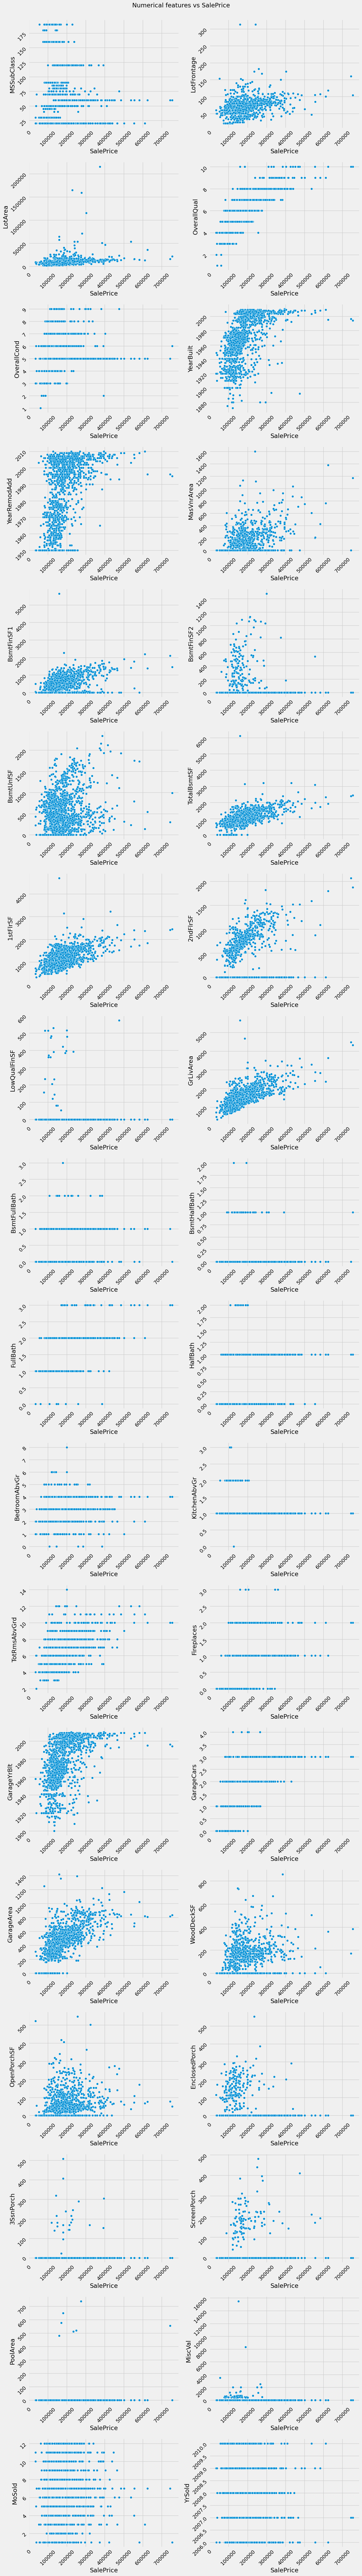

In [53]:
fig, axes = plt.subplots((len(numerical_features) + 1) // 2, 2, figsize=(14, 100))
axes = axes.flatten()
for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.scatterplot(
        data=real_train_df, x=target_col, y=feature, ax=ax, palette="viridis"
    )
    ax.tick_params(labelrotation=45)
fig.suptitle("Numerical features vs SalePrice")
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [137]:
def preprocess_df(df):
    df = df.copy()

    df.loc[df["LotFrontage"] > 150, "LotFrontage"] = 150
    df.loc[df["MasVnrArea"] > 900, "MasVnrArea"] = 900
    df.loc[df["BsmtFinSF1"] > 1700, "BsmtFinSF1"] = 1700
    df.loc[df["TotalBsmtSF"] > 2500, "TotalBsmtSF"] = 2500
    df.loc[df["1stFlrSF"] > 2500, "1stFlrSF"] = 2500
    df.loc[df["GrLivArea"] > 3750, "GrLivArea"] = 3750
    df.loc[df["BedroomAbvGr"] > 6, "BedroomAbvGr"] = 6
    df.loc[df["TotRmsAbvGrd"] > 12, "TotRmsAbvGrd"] = 12
    df.loc[df["LotArea"] > 45000, "Year"] = 45000
    df["MSSubClass"] = df["MSSubClass"].astype(str)

    df["ENGSpaciousness"] = (df["1stFlrSF"] + df["2ndFlrSF"]) / df["TotRmsAbvGrd"]
    df["ENGLivLotRatio"] = df["GrLivArea"] / df["LotArea"]
    df["ENGHouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["ENGRemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    df["ENGTotalBath"] = (
        df["FullBath"]
        + (0.5 * df["HalfBath"])
        + df["BsmtFullBath"]
        + (0.5 * df["BsmtHalfBath"])
    )
    df["ENGTotalLot"] = df["LotFrontage"] + df["LotArea"]
    df["ENGTotalBsmtFin"] = df["BsmtFinSF1"] + df["BsmtFinSF2"]
    df["ENGTotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    df["ENGTotalSFinclGarage"] = (
        df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"] + df["GarageArea"]
    )
    df["ENGTotalBath"] = (
        df["FullBath"]
        + (0.5 * df["HalfBath"])
        + df["BsmtFullBath"]
        + (0.5 * df["BsmtHalfBath"])
    )
    df["ENGTotalPorch"] = (
        df["OpenPorchSF"] + df["EnclosedPorch"] + df["ScreenPorch"] + df["3SsnPorch"]
    )
    df["ENGOverallCondQual"] = df["OverallCond"] * df["OverallQual"]
    df["ENGExtOverallQual"] = df["OverallQual"] * df["ExterQual"]
    df["ENGGarageCarsXArea"] = df["GarageCars"] * df["GarageArea"]
    df["ENGTotalSFQual"] = df["ENGTotalSF"] * df["OverallQual"]
    df["ENGLivQual"] = df["GrLivArea"] * df["OverallQual"]
    df["ENGLotAreaxOverallQual"] = df["LotArea"] * df["OverallQual"]

    df["ENGHasPorch"] = df["ENGTotalPorch"].apply(lambda x: 1 if x > 0 else 0)
    df["ENGHasBsmt"] = df["ENGTotalBsmtFin"].apply(lambda x: 1 if x > 0 else 0)
    df["ENGHasGarage"] = df["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
    df["ENGHasFireplace"] = df["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)
    df["ENGHas2ndFloor"] = df["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
    df["ENGHasWoodDeck"] = df["WoodDeckSF"].apply(lambda x: 1 if x > 0 else 0)
    df["ENGHasMasVnr"] = df["MasVnrArea"].apply(lambda x: 1 if x > 0 else 0)
    df["ENGHasAlley"] = df["Alley"].apply(lambda x: 0 if x == "None" else 1)
    df["ENGHas3SsnPorch"] = df["3SsnPorch"].apply(lambda x: 1 if x > 0 else 0)
    df["ENGHasScreenPorch"] = df["ScreenPorch"].apply(lambda x: 1 if x > 0 else 0)
    df["ENGHasEnclosedPorch"] = df["EnclosedPorch"].apply(lambda x: 1 if x > 0 else 0)

    df.drop(["PoolQC", "YrSold", "Electrical", "MiscVal"], axis=1, inplace=True)

    return df

In [138]:
train_df = real_train_df.copy()
test_df = real_test_df.copy()
train_df = preprocess_df(train_df)
test_df = preprocess_df(real_test_df)
numerical_features = list(test_df.select_dtypes(include="number").columns)
categorical_features = list(test_df.select_dtypes(exclude="number").columns)

# numerical_features = ["LotArea", "YearBuilt", "1stFlrSF", "2ndFlrSF", "GrLivArea", "FullBath", "HalfBath", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "GarageArea", "PoolArea", "YrSold"]
# categorical_features = ["LotShape", "LotConfig", "LandSlope", "Neighborhood", "RoofMatl", "Foundation", "GarageType", "Fence", "SaleCondition"]

for feature in numerical_features:
    train_df[feature] = train_df[feature].fillna(train_df[feature].median())
    test_df[feature] = test_df[feature].fillna(test_df[feature].median())
for feature in categorical_features:
    train_df[feature] = train_df[feature].fillna(train_df[feature].mode()[0])
    test_df[feature] = test_df[feature].fillna(test_df[feature].mode()[0])

label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    train_features = set(train_df[feature].values)
    test_features = set(test_df[feature].values)
    features = list(train_features.union(test_features))
    le.fit(features)
    train_df[feature] = le.transform(train_df[feature])
    test_df[feature] = le.transform(test_df[feature])
    label_encoders[feature] = le

print(numerical_features)
print(categorical_features)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'Year', 'ENGSpaciousness', 'ENGLivLotRatio', 'ENGHouseAge', 'ENGRemodAge', 'ENGTotalBath', 'ENGTotalLot', 'ENGTotalBsmtFin', 'ENGTotalSF', 'ENGTotalSFinclGarage', 'ENGTotalPorch', 'ENGOverallCondQual', 'ENGGarageCarsXArea', 'ENGTotalSFQual', 'ENGLivQual', 'ENGLotAreaxOverallQual', 'ENGHasPorch', 'ENGHasBsmt', 'ENGHasGarage', 'ENGHasFireplace', 'ENGHas2ndFloor', 'ENGHasWoodDeck', 'ENGHasMasVnr', 'ENGHasAlley', 'ENGHas3SsnPorch', 'ENGHasScreenPorch', 'ENGHasEnclosedPorch']
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 

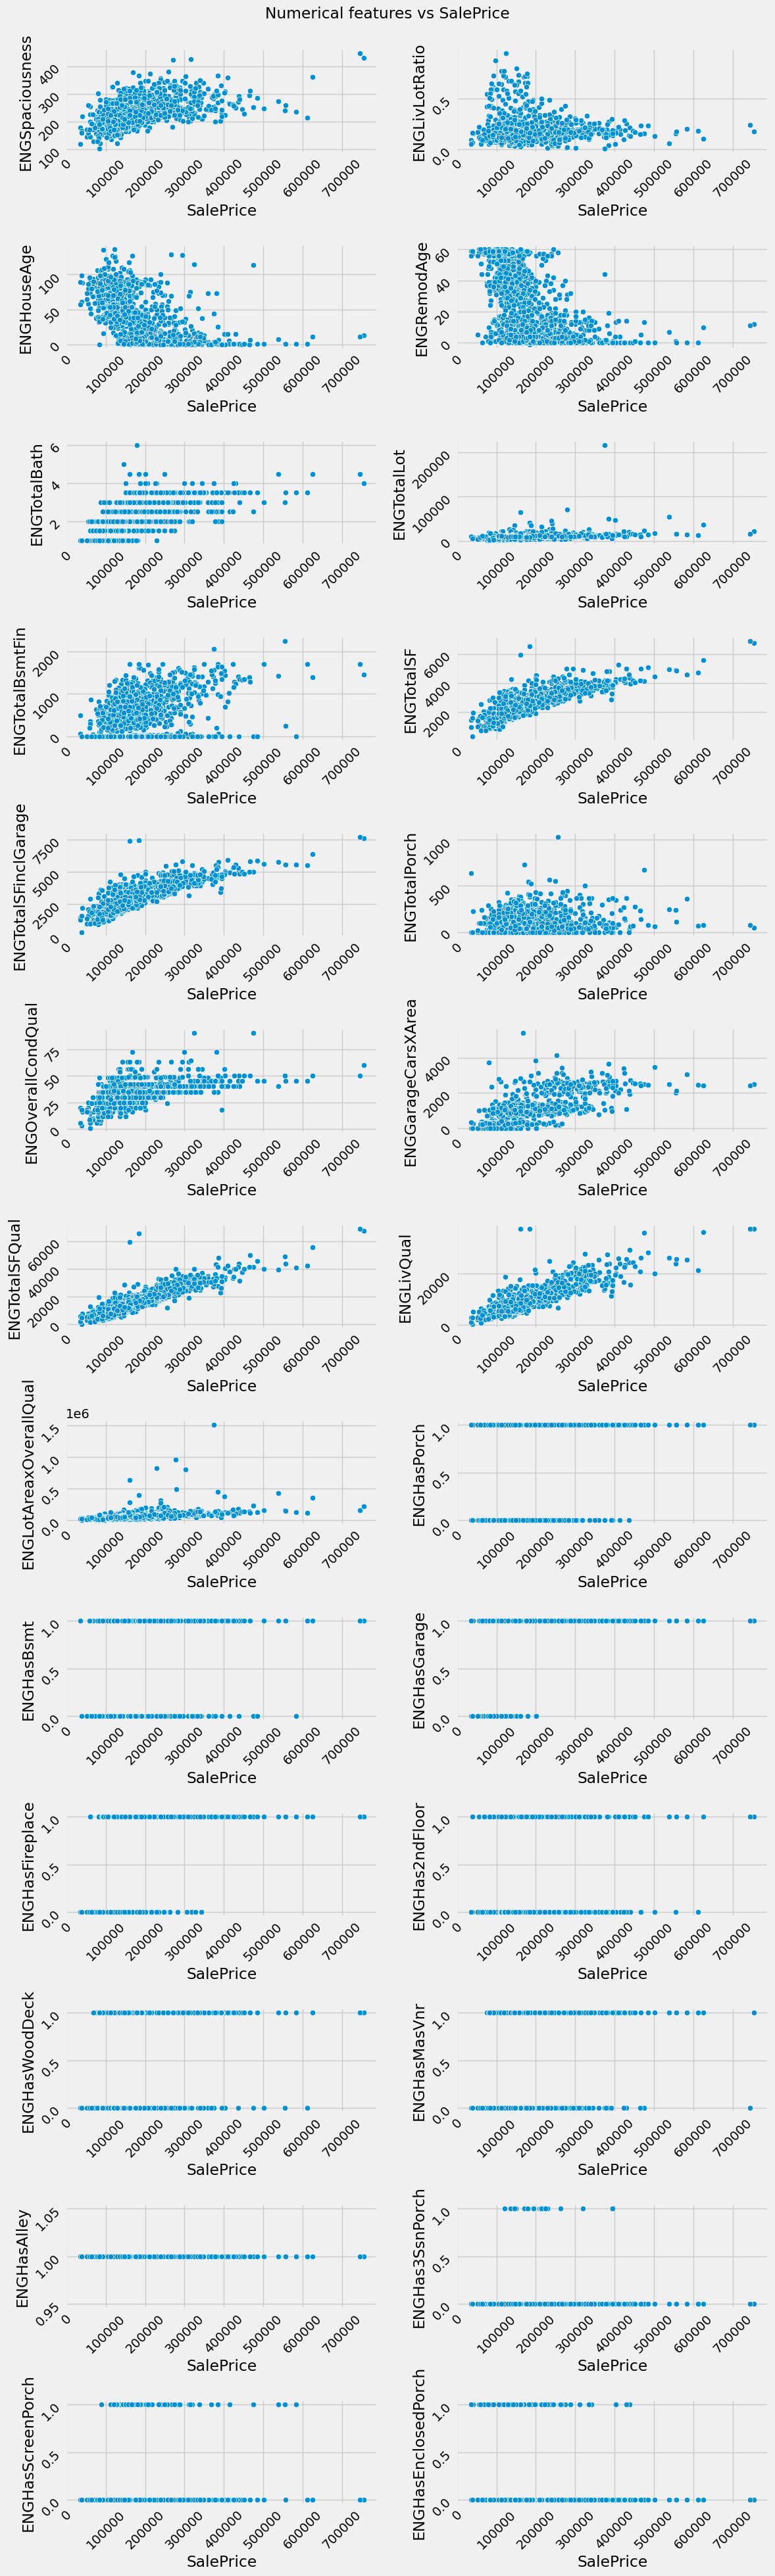

In [139]:
eng_features = [i for i in numerical_features if i.startswith("ENG")]
fig, axes = plt.subplots((len(eng_features) + 1) // 2, 2, figsize=(12, 40))
axes = axes.flatten()
for i, feature in enumerate(eng_features):
    ax = axes[i]
    sns.scatterplot(data=train_df, x=target_col, y=feature, ax=ax, palette="viridis")
    ax.tick_params(labelrotation=45)
fig.suptitle("Numerical features vs SalePrice")
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [140]:
def rmse(y_true, y_pred):
    # The competition uses the logarithms of original and predictions instead of below
    # return np.sqrt(((y_true - y_pred) ** 2).sum() / len(y_true))
    return np.sqrt(((np.log(y_true) - np.log(y_pred)) ** 2).sum() / len(y_true))
    # return sum(abs(y_true - y_pred)) / len(y_true)


def train(model, cv):
    df = train_df.copy()
    x = df[categorical_features + numerical_features]
    y = df[target_col]

    pipeline = model
    train_scores = []
    val_scores = []

    print(f"Training Model: {model.__class__.__name__}")
    for train_idx, val_idx in cv.split(x, y):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(x_train, y_train)

        train_preds = pipeline.predict(x_train)
        val_preds = pipeline.predict(x_val)
        train_score = rmse(y_train, train_preds)
        val_score = rmse(y_val, val_preds)
        train_scores.append(train_score)
        val_scores.append(val_score)

    train_mean, train_std = np.mean(train_scores), np.std(train_scores)
    val_mean, val_std = np.mean(val_scores), np.std(val_scores)
    print(f"  Training RMSE: {round(train_mean, 5)} ± {round(train_std, 5)}")
    print(f"Validation RMSE: {round(val_mean, 5)} ± {round(val_std, 5)}")
    print()

    return train_scores, val_scores


def train_with_features(model, cv, features):
    df = train_df.copy()
    x = df[features]
    y = df[target_col]

    pipeline = model
    train_scores = []
    val_scores = []

    print(f"Training Model: {model.__class__.__name__}")
    for train_idx, val_idx in cv.split(x, y):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(x_train, y_train)

        train_preds = pipeline.predict(x_train)
        val_preds = pipeline.predict(x_val)
        train_score = rmse(y_train, train_preds)
        val_score = rmse(y_val, val_preds)
        train_scores.append(train_score)
        val_scores.append(val_score)

    train_mean, train_std = np.mean(train_scores), np.std(train_scores)
    val_mean, val_std = np.mean(val_scores), np.std(val_scores)
    print(f"  Training RMSE: {round(train_mean, 5)} ± {round(train_std, 5)}")
    print(f"Validation RMSE: {round(val_mean, 5)} ± {round(val_std, 5)}")
    print()

    return train_scores, val_scores


def predict(model):
    df = train_df.copy()
    x_train = df[categorical_features + numerical_features]
    y_train = df[target_col]
    x_test = test_df.copy()[categorical_features + numerical_features]

    pipeline = model

    print(f"Training Model: {model.__class__.__name__}")
    pipeline.fit(x_train, y_train)
    train_preds = pipeline.predict(x_train)
    train_score = rmse(y_train, train_preds)
    print(f"Training RMSE: {round(train_score, 5)}")

    test_preds = pipeline.predict(x_test)
    return test_preds


def train_voting_regressor(models, cv):
    model = VotingRegressor([(model.__class__.__name__, model) for model in models])
    return predict(model, cv)


def predict_voting_regressor(models):
    model = VotingRegressor([(model.__class__.__name__, model) for model in models])
    return predict(model)

In [133]:
cls = LGBMRegressor
model = cls(random_state=42)
kf_cv = KFold(n_splits=10, random_state=42, shuffle=True)

print("Training Initial Model to determine feature importances")

_ = train(model, kf_cv)
features = categorical_features + numerical_features
feature_importances = model.feature_importances_

feature_df = pd.DataFrame({"feature": features, "importance": feature_importances})
feature_df.sort_values(by="importance", ascending=False, inplace=True)
ordered_features = list(feature_df["feature"].values)
feature_quality_df = pd.DataFrame()

print("Finding best number of features")

increment = 2
for i in range(1, len(ordered_features), increment):
    top_k_features = ordered_features[:i]
    model = cls(random_state=42)
    train_scores, val_scores = train_with_features(model, kf_cv, top_k_features)
    train_mean, train_std = np.mean(train_scores), np.std(train_scores)
    val_mean, val_std = np.mean(val_scores), np.std(val_scores)
    feature_quality_df = feature_quality_df.append(
        {
            "model": model.__class__.__name__,
            "num_features": i,
            "train_mean": round(train_mean, 3),
            "train_std": round(train_std, 3),
            "val_mean": round(val_mean, 3),
            "val_std": round(val_std, 3),
            "features": top_k_features,
        },
        ignore_index=True,
    )

Training Initial Model to determine feature importances
Training Model: LGBMRegressor
  Training RMSE: 0.05004 ± 0.0015
Validation RMSE: 0.13256 ± 0.02249

Finding best number of features
Training Model: LGBMRegressor
  Training RMSE: 0.1683 ± 0.00197
Validation RMSE: 0.18453 ± 0.01804

Training Model: LGBMRegressor
  Training RMSE: 0.12592 ± 0.00191
Validation RMSE: 0.17468 ± 0.01987

Training Model: LGBMRegressor
  Training RMSE: 0.10695 ± 0.00226
Validation RMSE: 0.17182 ± 0.01885

Training Model: LGBMRegressor
  Training RMSE: 0.09831 ± 0.00167
Validation RMSE: 0.16898 ± 0.0174

Training Model: LGBMRegressor
  Training RMSE: 0.0826 ± 0.00163
Validation RMSE: 0.15406 ± 0.01768

Training Model: LGBMRegressor
  Training RMSE: 0.07851 ± 0.00116
Validation RMSE: 0.15282 ± 0.0177

Training Model: LGBMRegressor
  Training RMSE: 0.07492 ± 0.00153
Validation RMSE: 0.15198 ± 0.0189

Training Model: LGBMRegressor
  Training RMSE: 0.07341 ± 0.00152
Validation RMSE: 0.15178 ± 0.01919

Training 

In [134]:
feature_quality_df["val_plus_std"] = (
    feature_quality_df["val_mean"] + feature_quality_df["val_std"]
)
# feature_quality_df = feature_quality_df.sort_values(by=["val_plus_std", "num_features"])
feature_quality_df = feature_quality_df.sort_values(by=["val_mean", "num_features"])
feature_quality_df

model  num_features  train_mean  train_std  val_mean  val_std  \
31  LGBMRegressor            63       0.050      0.002     0.131    0.021   
19  LGBMRegressor            39       0.052      0.001     0.132    0.022   
21  LGBMRegressor            43       0.052      0.001     0.132    0.023   
22  LGBMRegressor            45       0.052      0.001     0.132    0.023   
23  LGBMRegressor            47       0.051      0.001     0.132    0.022   
25  LGBMRegressor            51       0.051      0.002     0.132    0.021   
26  LGBMRegressor            53       0.050      0.002     0.132    0.021   
27  LGBMRegressor            55       0.050      0.001     0.132    0.022   
30  LGBMRegressor            61       0.050      0.002     0.132    0.021   
32  LGBMRegressor            65       0.050      0.002     0.132    0.021   
33  LGBMRegressor            67       0.050      0.002     0.132    0.020   
34  LGBMRegressor            69       0.050      0.002     0.132    0.022   
36  LGBMRegressor            73       0.050      0.002     0.132    0.023   
37  LGBMRegressor            75       0.050      0.002     0.132    0.023   
38  LGBMRegressor            77       0.050      0.002     0.132    0.023   
17  LGBMRegressor            35       0.053      0.002     0.133    0.022   
18  LGBMRegressor            37       0.053      0.001     0.133    0.021   
20  LGBMRegressor            41       0.052      0.002     0.133    0.022   
24  LGBMRegressor            49       0.051      0.002     0.133    0.021   
28  LGBMRegressor            57       0.050      0.002     0.133    0.021   
29  LGBMRegressor            59       0.050      0.001     0.133    0.021   
35  LGBMRegressor            71       0.050      0.002     0.133    0.023   
39  LGBMRegressor            79       0.050      0.002     0.133    0.022   
40  LGBMRegressor            81       0.050      0.002     0.133    0.022   
41  LGBMRegressor            83       0.050      0.002     0.133    0.022   
42  LGBMRegressor            85       0.050      0.002     0.133    0.022   
43  LGBMRegressor            87       0.050      0.002     0.133    0.022   
44  LGBMRegressor            89       0.050      0.002     0.133    0.022   
45  LGBMRegressor            91       0.050      0.002     0.133    0.022   
46  LGBMRegressor            93       0.050      0.002     0.133    0.022   
47  LGBMRegressor            95       0.050      0.002     0.133    0.022   
48  LGBMRegressor            97       0.050      0.002     0.133    0.022   
49  LGBMRegressor            99       0.050      0.002     0.133    0.022   
15  LGBMRegressor            31       0.055      0.001     0.135    0.020   
16  LGBMRegressor            33       0.054      0.001     0.135    0.022   
12  LGBMRegressor            25       0.057      0.001     0.137    0.022   
13  LGBMRegressor            27       0.057      0.002     0.137    0.021   
11  LGBMRegressor            23       0.058      0.001     0.138    0.022   
14  LGBMRegressor            29       0.056      0.001     0.138    0.020   
10  LGBMRegressor            21       0.062      0.001     0.144    0.020   
9   LGBMRegressor            19       0.068      0.001     0.150    0.018   
8   LGBMRegressor            17       0.071      0.001     0.151    0.018   
6   LGBMRegressor            13       0.075      0.002     0.152    0.019   
7   LGBMRegressor            15       0.073      0.002     0.152    0.019   
5   LGBMRegressor            11       0.079      0.001     0.153    0.018   
4   LGBMRegressor             9       0.083      0.002     0.154    0.018   
3   LGBMRegressor             7       0.098      0.002     0.169    0.017   
2   LGBMRegressor             5       0.107      0.002     0.172    0.019   
1   LGBMRegressor             3       0.126      0.002     0.175    0.020   
0   LGBMRegressor             1       0.168      0.002     0.185    0.018   

                                             features  val_plus_std  
31  [ENGTotalS

In [141]:
seed = 1337
np.random.seed(seed)

models = [
    # AdaBoostRegressor(random_state=seed),
    CatBoostRegressor(random_state=seed, verbose=0),
    # ExtraTreesRegressor(random_state=seed),
    GradientBoostingRegressor(random_state=seed),
    HistGradientBoostingRegressor(random_state=seed),
    LGBMRegressor(random_state=seed),
    # LinearRegression(),
    # RandomForestRegressor(random_state=seed),
    XGBRegressor(random_state=seed),
]
model_map = {model.__class__.__name__: model for model in models}

kf_cv = KFold(n_splits=10, random_state=seed, shuffle=True)

In [142]:
scores = pd.DataFrame()
for model in models:
    name = model.__class__.__name__
    # _, scores[name] = train_with_features(model, kf_cv, feature_quality_df["features"].iloc[0])
    _, scores[name] = train(model, kf_cv)

Training Model: CatBoostRegressor
  Training RMSE: 0.03699 ± 0.00125
Validation RMSE: 0.12351 ± 0.02272

Training Model: GradientBoostingRegressor
  Training RMSE: 0.08451 ± 0.00077
Validation RMSE: 0.13476 ± 0.02383

Training Model: HistGradientBoostingRegressor
  Training RMSE: 0.04906 ± 0.00211
Validation RMSE: 0.13376 ± 0.01954

Training Model: LGBMRegressor
  Training RMSE: 0.04948 ± 0.00221
Validation RMSE: 0.13442 ± 0.01836

Training Model: XGBRegressor
  Training RMSE: 0.00683 ± 0.0004
Validation RMSE: 0.13773 ± 0.019



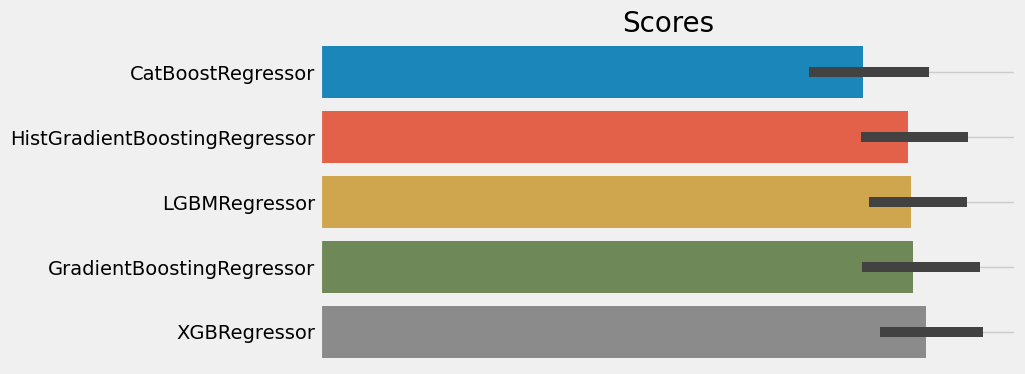

In [143]:
plt.figure(figsize=(8, 4))
sns.barplot(data=scores.reindex(scores.mean().sort_values().index, axis=1), orient="h")
plt.title("Scores", size=20)
plt.xticks([])
plt.grid(None)
plt.show()

In [144]:
# top_k = 3
# model_names = scores.reindex(scores.mean().sort_values().index, axis=1).columns[:top_k]
model_names = ["CatBoostRegressor"]  # , "LGBMRegressor"]
best_models = [model_map[name] for name in model_names]

CatBoostRegressor


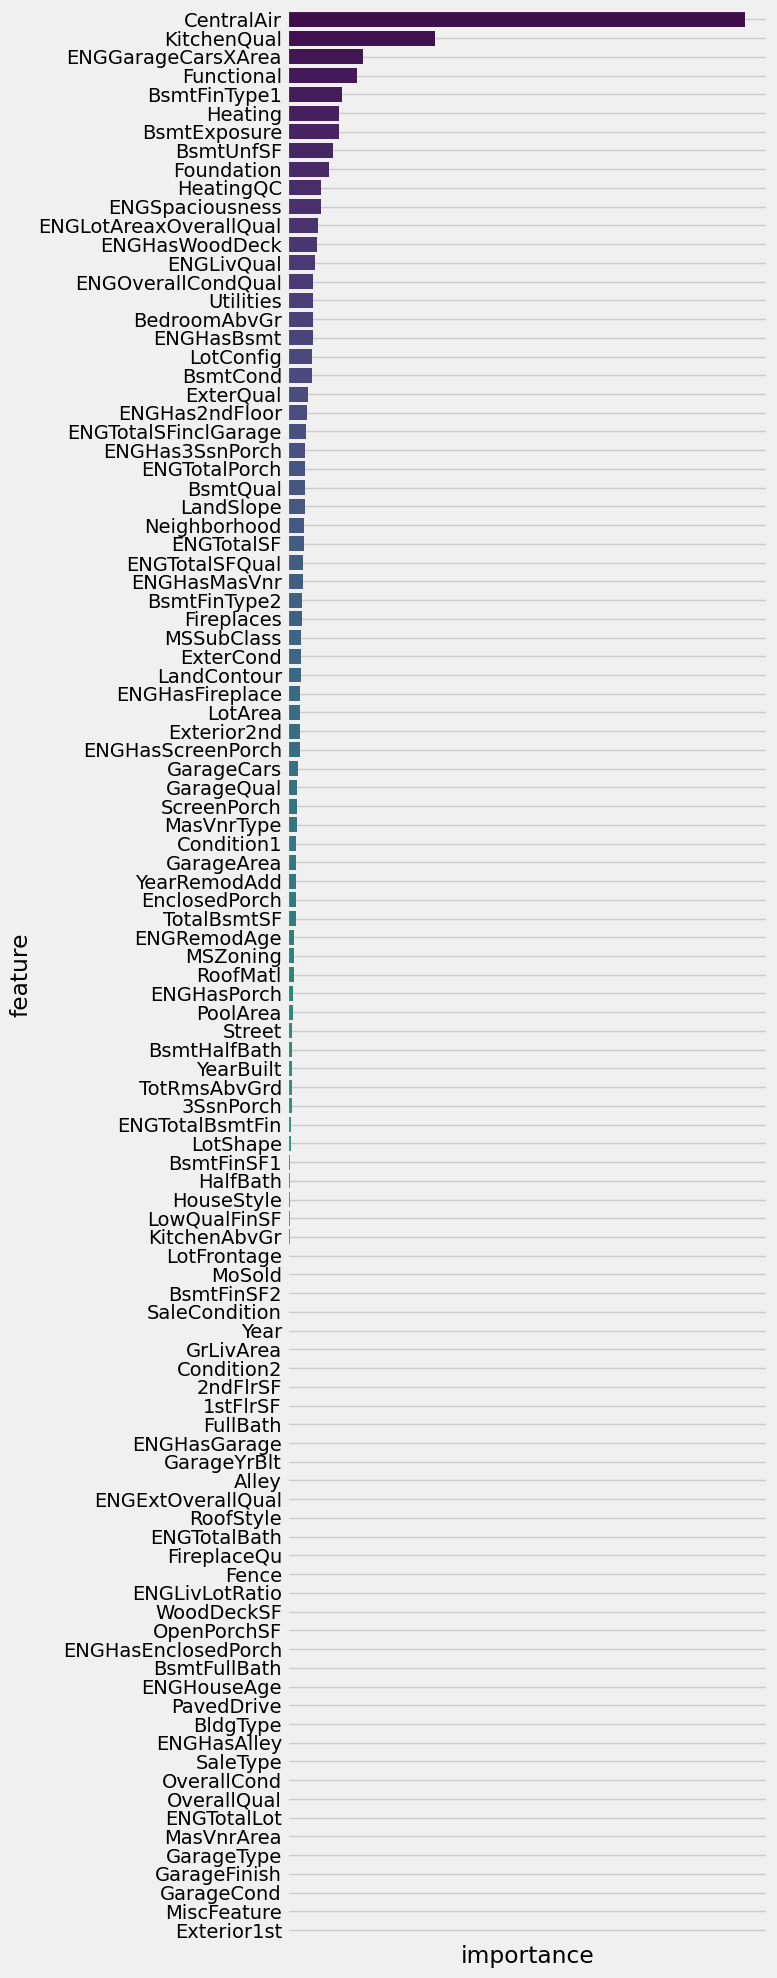

In [145]:
# features = feature_quality_df["features"].iloc[0]
features = numerical_features + categorical_features
feature_importances = np.zeros((len(features)))

for model in best_models:
    if hasattr(model, "feature_importances_") and len(
        model.feature_importances_
    ) == len(features):
        print(model.__class__.__name__)
        feature_importances += model.feature_importances_

feature_df = pd.DataFrame({"feature": features, "importance": feature_importances})
feature_df.sort_values(by="importance", ascending=False, inplace=True)

plt.figure(figsize=(8, 20))
sns.barplot(data=feature_df, x="importance", y="feature", palette="viridis")
plt.xticks([])
plt.grid(None)
plt.tight_layout()
plt.show()

In [146]:
submission_df = pd.read_csv("sample_submission.csv", index_col="Id")
submission_df[target_col] = predict_voting_regressor(best_models)

Training Model: VotingRegressor
Training RMSE: 0.0387


In [147]:
submission_df.to_csv("VotingRegressor-v4.csv")